# EDA

In [1]:
import pandas as pd
import string
import re
# nlp specific
import spacy
import nltk
from nltk import ngrams, FreqDist
from nltk.corpus import stopwords
# plots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# get stopwords
eng_stopwords = stopwords.words('english')
# init spacy
nlp = spacy.load("en_core_web_sm")

In [3]:
file_path = '/Users/sorenspiegel/PycharmProjects/Fake-News-and-Disinformation-related-to-COVID-19/data/fullset.csv'

In [4]:
df = pd.read_csv(file_path)

In [5]:
df.head(2)

tweet label  source
0  The CDC currently reports 99031 deaths. In gen...  real  sourya
1  States reported 1121 deaths a small rise from ...  real  sourya

# 1. base data info

In [6]:
df.shape

(14334, 3)

### 1.1. Nan values

In [7]:
print('NaN values:')
for col in df.columns:
    print(col, df[col].isna().sum())

NaN values:
tweet 1
label 0
source 0


In [8]:
# drop NaN
df = df.dropna(subset=['tweet']).copy()
df.shape

(14333, 3)

### 1.2. columns

In [9]:
df['label'].value_counts()

fake    8703
real    5630
Name: label, dtype: int64

In [10]:
df['source'].value_counts()

sourya         10699
Gautamshahi     3634
Name: source, dtype: int64

In [11]:
df.groupby('source')['label'].value_counts()

source       label
Gautamshahi  fake     3603
             real       31
sourya       real     5599
             fake     5100
Name: label, dtype: int64

In [12]:
df['tweet'].str.len().describe()

count    14333.000000
mean       163.508407
std        146.633256
min         11.000000
25%         94.000000
50%        139.000000
75%        233.000000
max      10170.000000
Name: tweet, dtype: float64

### 1.3. words in tweet

In [13]:
pd.merge(
    df[df['label']=='real']['tweet'].str.split().str.len().describe().rename('real'),
    df[df['label']=='fake']['tweet'].str.split().str.len().describe().rename('fake'),
    left_index=True,
    right_index=True
)

real         fake
count  5630.000000  8703.000000
mean     31.956128    19.929335
std      22.444207    21.794182
min       3.000000     1.000000
25%      23.000000    12.000000
50%      32.000000    16.000000
75%      40.000000    24.000000
max    1484.000000  1456.000000

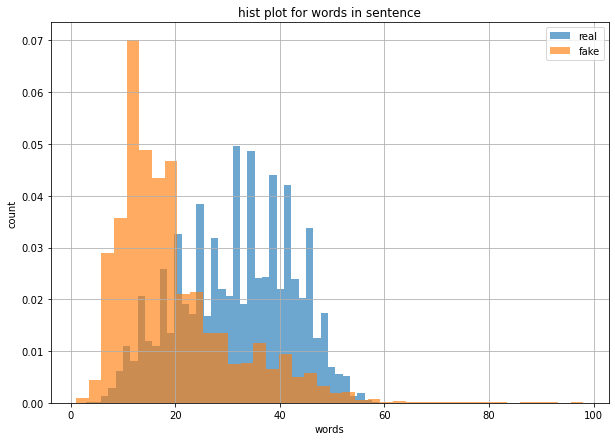

In [14]:
c_limit = 100
fig, ax = plt.subplots(figsize=(10,7))
tmp_s = df[df['label']=='real']['tweet'].str.split().str.len()
tmp_s[tmp_s < c_limit].hist(bins=40, alpha=0.65, label='real', density=True, ax=ax)
tmp_s = df[df['label']=='fake']['tweet'].str.split().str.len()
tmp_s[tmp_s < c_limit].hist(bins=40, alpha=0.65, label='fake', density=True, ax=ax)
plt.title('hist plot for words in sentence')
ax.set_xlabel('words')
ax.set_ylabel('count')
plt.legend()
plt.show()

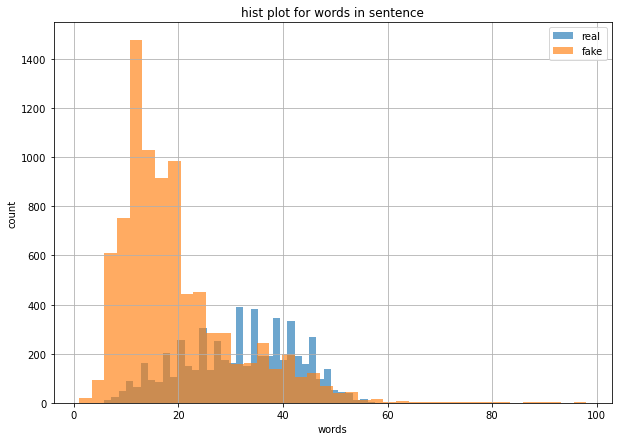

In [15]:
c_limit = 100
fig, ax = plt.subplots(figsize=(10,7))
tmp_s = df[df['label']=='real']['tweet'].str.split().str.len()
tmp_s[tmp_s < c_limit].hist(bins=40, alpha=0.65, label='real', ax=ax)
tmp_s = df[df['label']=='fake']['tweet'].str.split().str.len()
tmp_s[tmp_s < c_limit].hist(bins=40, alpha=0.65, label='fake', ax=ax)
plt.title('hist plot for words in sentence')
ax.set_xlabel('words')
ax.set_ylabel('count')
plt.legend()
plt.show()

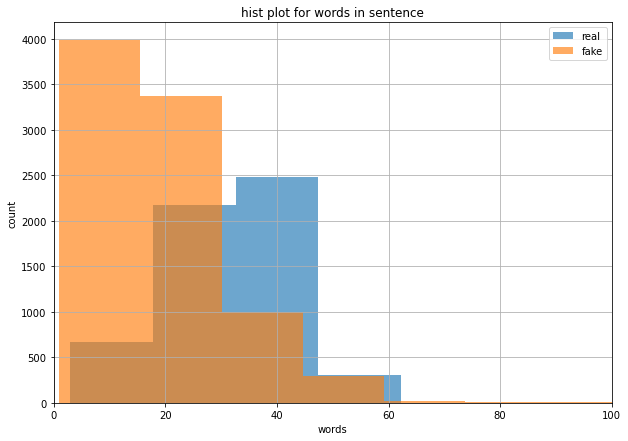

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
df[df['label']=='real']['tweet'].str.split().str.len().hist(bins=100, alpha=0.65, label='real', ax=ax)
df[df['label']=='fake']['tweet'].str.split().str.len().hist(bins=100, alpha=0.65, label='fake', ax=ax)
plt.title('hist plot for words in sentence')
plt.xlim(0,100)
ax.set_xlabel('words')
ax.set_ylabel('count')
plt.legend()
plt.show()

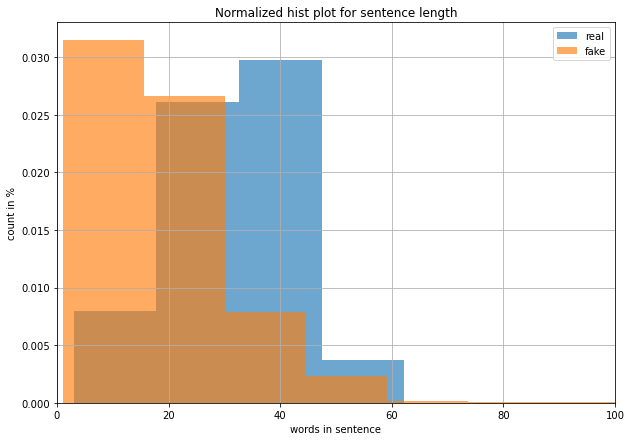

In [17]:
fig, ax = plt.subplots(figsize=(10,7))
df[df['label']=='real']['tweet'].str.split().str.len().hist(bins=100, alpha=0.65, label='real', density=True, ax=ax)
df[df['label']=='fake']['tweet'].str.split().str.len().hist(bins=100, alpha=0.65, label='fake', density=True, ax=ax)
plt.title('Normalized hist plot for sentence length')
plt.xlim(0,100)
ax.set_xlabel('words in sentence')
ax.set_ylabel('count in %')
plt.legend()
plt.show()

# 2. data prep for text

In [18]:
def prep_tweet(sentence, stopwords=True, lemma=True, lower=True):
    # Method for article title preprocessing
    if lower:
        sentence = sentence.lower()
    sentence = re.sub('\[.*?\]', '', sentence)
    sentence = re.sub('[%s]' % re.escape(string.punctuation), '', sentence)
    sentence = re.sub('<.*?>+', '', sentence)
    sentence = re.sub('\n', '', sentence)
    sentence = re.sub('[^A-Za-z1-9]', ' ', sentence)
    doc = nlp(sentence, disable=['ner', 'parser'])
    if stopwords:
        sentence = [token for token in doc if token.text not in eng_stopwords]
    else:
        sentence = [token for token in doc]
    if lemma:
        sentence = [token.lemma_.strip() for token in sentence]
    return ' '.join(sentence)

In [19]:
%%time
# preprocess title
df['tweet'] = df.apply(lambda x: prep_tweet(x['tweet'], stopwords=False, lower=False), axis=1)

CPU times: user 35.1 s, sys: 187 ms, total: 35.3 s
Wall time: 35.2 s


# 3. NER with Organisations in tweets

In [20]:
def get_entity(sentence, org_list, ent_label='ORG'):
    doc = nlp(sentence)
    if doc.ents:
        for ent in doc.ents:
            if ent.label_ == ent_label:
                org_list.append(ent.text.lower())
    return org_list

In [21]:
# get organization entity from tweets
fake_organizations = list()
real_organizations = list()
df[df['label']=='fake'].apply(lambda x: get_entity(x['tweet'], fake_organizations), axis=1)
df[df['label']=='real'].apply(lambda x: get_entity(x['tweet'], real_organizations), axis=1)

0        [cdc, indiafightscorona, texas al ar id, ks ky...
1        [cdc, indiafightscorona, texas al ar id, ks ky...
3        [cdc, indiafightscorona, texas al ar id, ks ky...
4        [cdc, indiafightscorona, texas al ar id, ks ky...
5        [cdc, indiafightscorona, texas al ar id, ks ky...
                               ...                        
12719    [cdc, indiafightscorona, texas al ar id, ks ky...
12727    [cdc, indiafightscorona, texas al ar id, ks ky...
12733    [cdc, indiafightscorona, texas al ar id, ks ky...
12836    [cdc, indiafightscorona, texas al ar id, ks ky...
12908    [cdc, indiafightscorona, texas al ar id, ks ky...
Length: 5630, dtype: object

In [22]:
len(fake_organizations), len(real_organizations)

(3476, 3242)

In [23]:
# build df
df_org = pd.DataFrame(
    {'org': fake_organizations, 'label': 'fake'}
).append(pd.DataFrame({'org': real_organizations, 'label': 'real'}))

In [24]:
df_org.sample(2)

org label
52    antiracismctr  real
2232    trump tweet  fake

In [25]:
# cdc: Center for Disease Control and Prevention
# icu: Insensive Care Unit
# afp: Agence France Presse
# ppe: personal protective equipment
# factly: https://factly.in/ (has telegram chanel) :D

In [26]:
def get_topn_orgs(df, label1, label2, n):
    # method to get top N organisation with count from label 1 and join count for label 2
    df_tmp = pd.DataFrame(df[df['label']==label1]['org'].value_counts().rename(label1)[:n])
    return df_tmp.join(
        df[(df['label']==label2) & (df_org['org'].isin(df_tmp.index))]['org'].value_counts().rename(label2)
    )

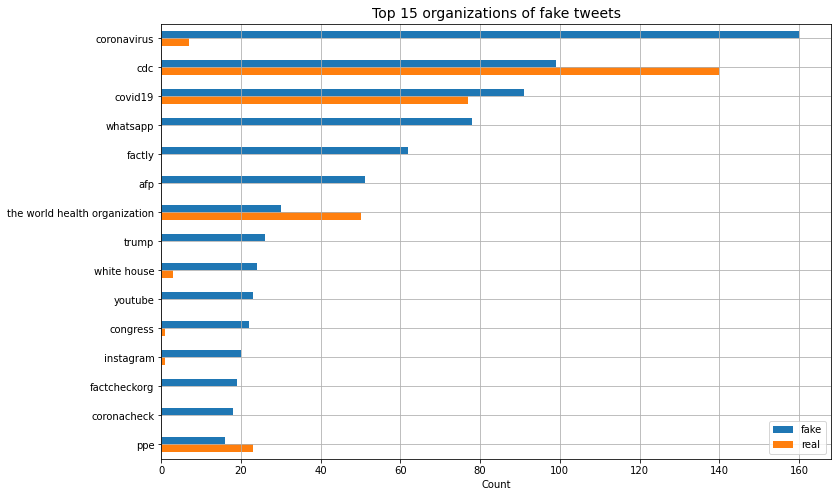

In [27]:
top_n = 15
label1 = 'fake'
label2 = 'real'
fig, ax = plt.subplots(figsize=(12,8))

# plot
get_topn_orgs(df_org, label1, label2, top_n).plot.barh(ax=ax)
# style
ax.invert_yaxis()
ax.set_xlabel('Count')
ax.set_title(f'Top {top_n} organizations of {label1} tweets', fontsize=14)
plt.grid()
plt.show()

In [28]:
# ORG entity is probably more present in dataset than shwon in plot
df[df['tweet'].str.lower().str.contains('trump')]['label'].value_counts()

fake    565
real     21
Name: label, dtype: int64

In [29]:
df[df['tweet'].str.lower().str.contains('afp')].iloc[3]

tweet     philippine Department of Health refute hoax wa...
label                                                  fake
source                                          Gautamshahi
Name: 12987, dtype: object

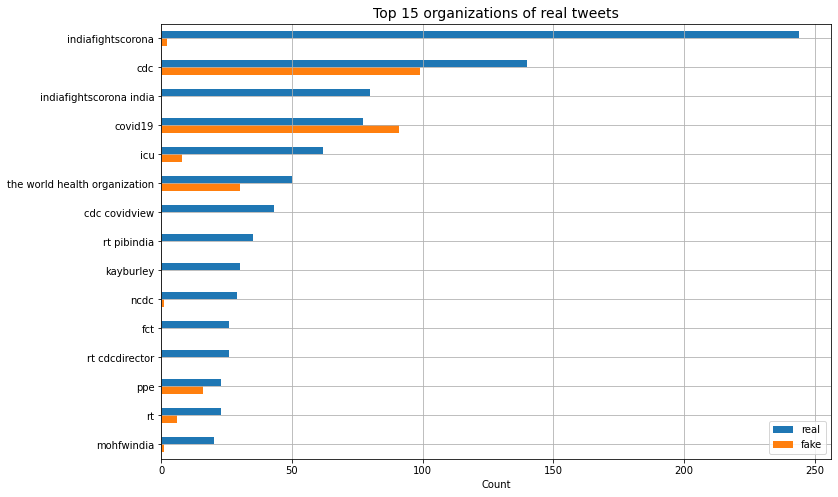

In [30]:
top_n = 15
label1 = 'real'
label2 = 'fake'
fig, ax = plt.subplots(figsize=(12,8))

# plot
get_topn_orgs(df_org, label1, label2, top_n).plot.barh(ax=ax)
# style
ax.invert_yaxis()
ax.set_xlabel('Count')
ax.set_title(f'Top {top_n} organizations of {label1} tweets', fontsize=14)
plt.grid()
plt.show()

# 4. WordClouds

In [31]:
def plot_wordcloud(df, stopwords, filter_label=None):
    # prep data
    if filter_label:
        text = ' '.join(df[df['label']==filter_label]['tweet'])
    else:
        text = ' '.join(df['tweet'])
    
    # word cloud
    wc = WordCloud(stopwords=stopwords, background_color="white").generate_from_text(text)
    
    # plot
    plt.figure(figsize=(16, 16))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

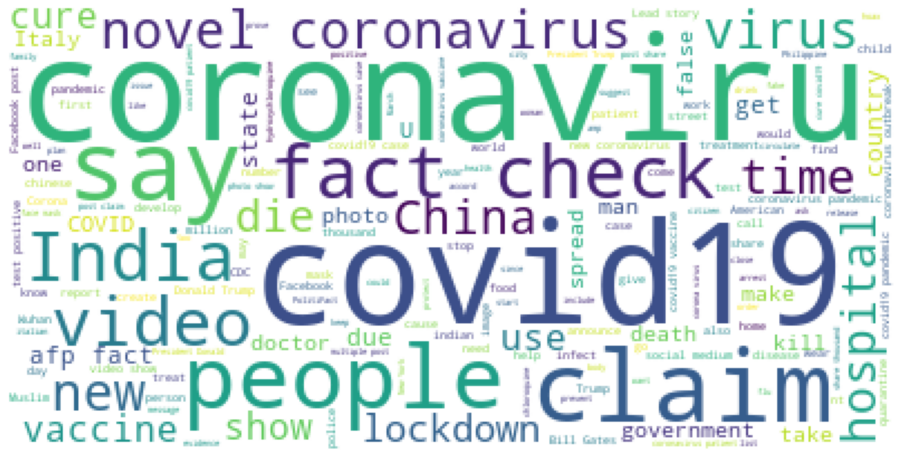

In [32]:
plot_wordcloud(df, eng_stopwords, filter_label='fake')

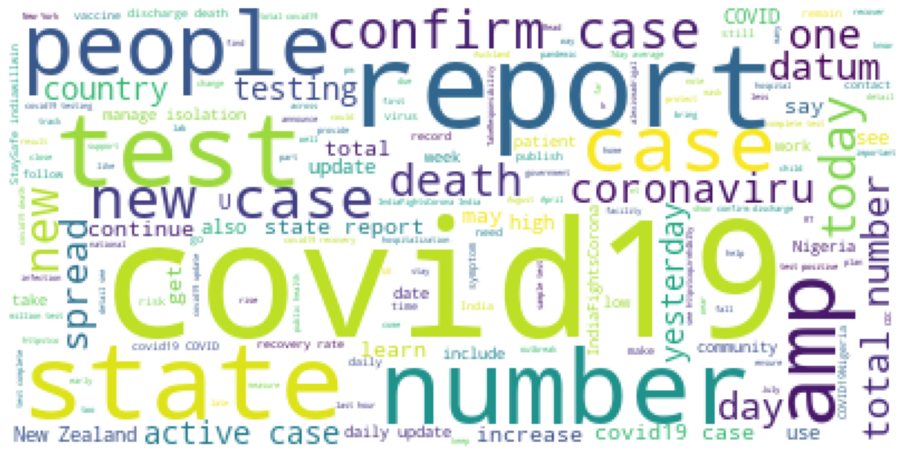

In [33]:
plot_wordcloud(df, eng_stopwords, filter_label='real')

# 5. word freq

In [34]:
def get_freq_for_label(df, label, stopwords):
    text = ' '.join(df[df['label']==label]['tweet'])
    # tokenize
    words = nltk.tokenize.word_tokenize(text)
    # remove stopwords
    words = [w.lower() for w in words if w.lower() not in eng_stopwords]
    return pd.Series(dict(FreqDist(words).most_common()), name=label)

In [35]:
def plot_word_freq(df, n=10, stopwords=None, filter_label=None):
    # filter df
    if filter_label in ['fake', 'real']:
        text = ' '.join(df[df['label']==filter_label]['tweet'])
    elif filter_label is None:
        text = ' '.join(df['tweet'])
    else:
        raise ValueError(f'Unexpected `filter_label`: {filter_label}. Abort')
    
    # tokenize
    words = nltk.tokenize.word_tokenize(text)
    
    # remove stopwords
    words = [w.lower() for w in words if w.lower() not in eng_stopwords]
    
    # get frequency
    n_fdist = pd.Series(dict(FreqDist(words).most_common(n)))
    
    # plot
    plt.figure(figsize=(16,8))
    n_fdist.plot(kind='bar')
    plt.title(f'top {n} words for label {filter_label}')
    plt.show()

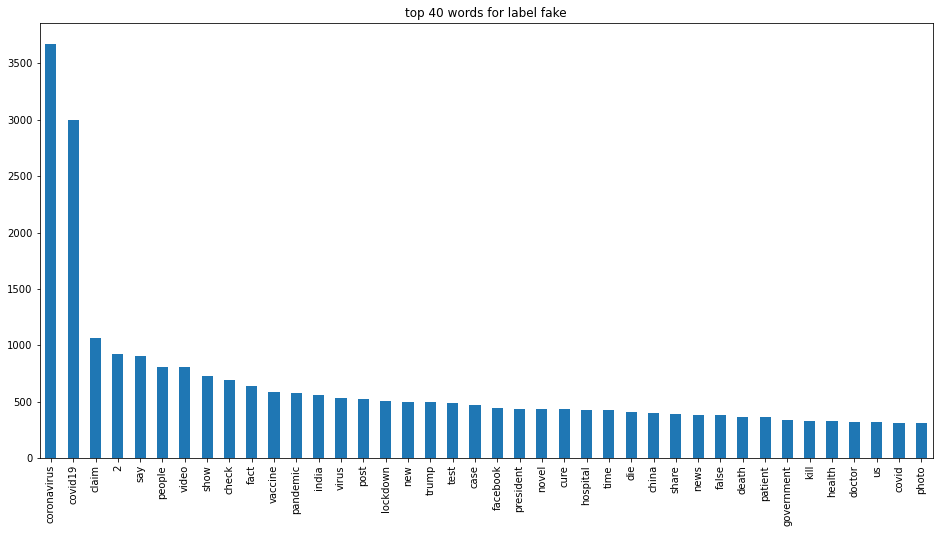

In [36]:
plot_word_freq(df, 40, filter_label='fake')

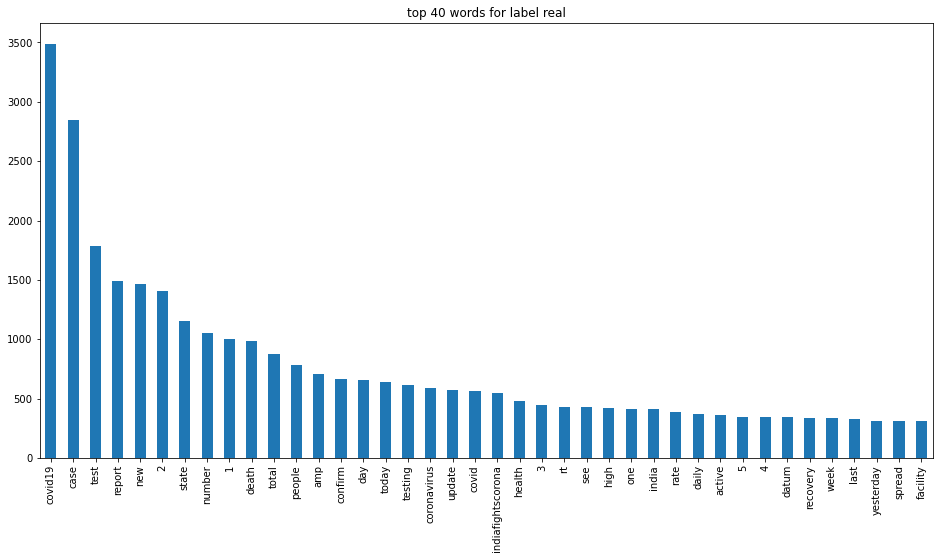

In [37]:
plot_word_freq(df, 40, filter_label='real')

In [38]:
# build df with frequency for fake and real words
df_freq = pd.merge(
    get_freq_for_label(df, 'fake', eng_stopwords),
    get_freq_for_label(df, 'real', eng_stopwords),
    right_index=True,
    left_index=True,
    how='outer'
)

In [39]:
n_words = 50
# get top n words from fake and real
def filter_for_topwords(df, label, n):
    return df.sort_values(by=label, ascending=False)[:n]
# build df for scatter plot
plt_df = filter_for_topwords(df_freq, 'fake', n_words).append(
    filter_for_topwords(df_freq, 'real', n_words)
).reset_index().rename(columns={'index': 'word'})
# add info for plot
plt_df['total'] = plt_df['real'] + plt_df['fake']

In [40]:
# plot scatter with plotly
fig = px.scatter(
    plt_df,
    x="fake",
    y="real",
    size='total',
    hover_data=['word'],
    title='Word Frequencies in Fake and Real Dataset'
)
fig.show()